# Logistic Regression Example
## Small Introduction

The general formula of linear regression is familiar to most, and is given by $Y = b_0+b_1 X_1$. Graphically, it represents a linear correlation between two continuous variables ($Y$ and $X_1$). But, what type of formula would we need in order to describe a binary variable?
It turns out that the best formula is logistic regression formula, which, when plotted, will have a sigmoid shape.
Here is a figure showing the distinction between linear and logistic regression:

<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/main/logistic_reg_intro.png" width=525 height=200 />


The aim of logistic regression modeling is to find the best formula that fits the data the best (i.e. with lowest error possible).

The formula of logistic regression is closely related to that of the linear regression, and is given by:

$$Probability (Y) = \frac{1}{1+e^{-(b
_2+...))}}$$ n
where $b_0$ is a constant, $b_1,b_2, ...$ are coefficients multiplied by their respective variables, $X_1, X_2, ...$ are the features in the dataset (AKA columns or variables).


<b>I know, I know! formulas make me anxious too. But don't worry, no manual calculations will be performed, python will take care of all that. But it's good to know the basics</b>



## About the Data Used
In this notebook, I will follow the analysis mentioned in the paper [Machine learning in medicine: a practical introduction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6425557/). The code in that paper is written in R. I translated it to python and modified it a little for the purposes of this course.

We will use for this course the dataset provided in the same paper mentioned above. This dataset was originally publicly available from the paper [Machine Learning Repository of University of California Irvine](http://archive.ics.uci.edu/).

This dataset [consists of characteristics, or features, of cell nuclei taken from breast masses which were sampled using fine-needle aspiration (FNA), a common diagnostic procedure in oncology. The clinical samples used to form this dataset were collected from January 1989 to November 1991.] (Sidey-Gibbons and Sidey-Gibbons 2019) Each sample is then classified as malignant or benign in the 'class' column (1= malignant and 0 = benign).



---
## Data Analysis Steps:
### 1. Import libraries and define functions

These are the functions that you will need for your following analyses. <b>This line calls the libraries and functions written in the utils.py file</b>. I kept these functions in another file just for simplicity. You can access it from [THIS LINK](https://github.com/abdulrahman1123/analysis_examples/blob/main/utils.py) if you need.

In [5]:
from utils import *

### 
### 2. Load the data



In [6]:
data_dir = 'https://github.com/abdulrahman1123/analysis_examples/raw/main/breast_cancer_wisconsin.csv'
data = pd.read_csv(data_dir)
data = data.iloc[0:200,:]

data

,ID,thickness,cell_size,cell_shape,adhesion,epithelial_size,bare_nuclei,bland_cromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
195,1212422,4,1,1,1,2,1.0,3,1,1,0
196,1213375,8,4,4,5,4,7.0,7,8,2,0
197,1213383,5,1,1,4,2,1.0,3,1,1,0
198,1214092,1,1,1,1,2,1.0,1,1,1,0


##### 2.1. Have a look at the 'class' variable and plot missing values

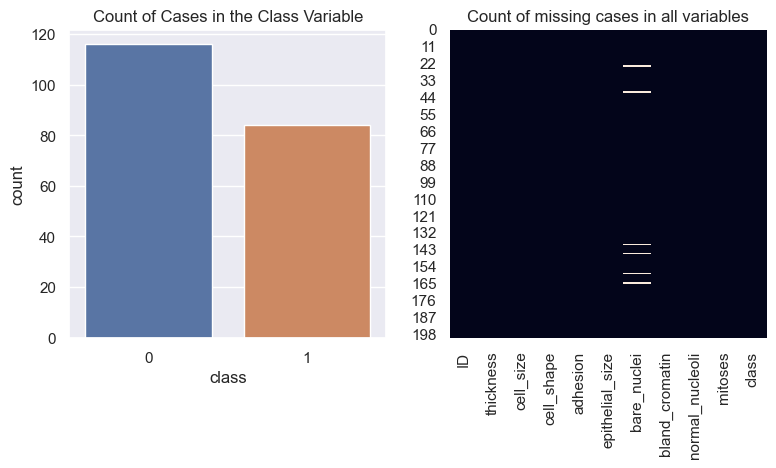

In [7]:
fig,(ax1,ax2) = plt.subplots(nrows = 1, ncols =2, figsize = (9,4))
sns.set_theme(style="darkgrid")
sns.countplot(x='class', data= data,ax = ax1)
ax1.set_title("Count of Cases in the Class Variable")

sns.heatmap(data.isnull(), cbar=False,ax= ax2)
ax2.set_title("Count of missing cases in all variables")

plt.show()

### 
### 3. Create training and test datasets

The following generally applies for all machine learning algorithms:

The first step to do is to <b>split your data into training and testing datasets</b>. The training dataset will be used to train the model and evaluate parameters, while the testing dataset will only be used at the end to test how well did the model learn.

The training dataset can be further divided into training and validation datasets, where the validation dataset is used to evaluate the parameters in order to reach to the best model. The way we will be doing this is represented in the following figure from [scikit-learn website](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=440 height=305 />

After splitting the data, we will impute the missing values using the mean of each column. This will be done separately for training and testing datasets.

Then, the data will be normalized (mean = 0 and sd = 1) so that the model can coverge faster (i.e. reach the best solution faster)

In [8]:
# Choose features
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

# Divide into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

print(f"Size of training dataset = {X_train.shape} and testing dataset = {X_test.shape}")

# Using the mean, impute the training and testing datasets separately
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train.copy())
X_test = imp.transform(X_test.copy())


# scale both X_train and X_test for faster convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Size of training dataset = (150, 9) and testing dataset = (50, 9)


### 
### 4. Create and fit the model

To create the best model, we want to use L1-regularization. This is basically a penalty that is applied to the model to remove irrelevant features.

L1-regularization basically assigns values for each of the variables to determine how sensitive the final model is to each of the variables. This regularization can be made more or less sensitive by modifying its parameter (C). Lower C values mean more sensitivity -> higher chance for variables to be removed. Higher C values mean less sensitivity and so on.

The aim of using regularization at all is to remove irrelevant variables and prevent overfitting

For further information, you can have a look at this [website](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) for simplified explanation of L1 regularization.

First, let's choose a number of c-values for the model to validate during training. The model will move over the values you provided to find the best value of C for the training dataset. <i>(Note: If you do not provide a list of Cs, it will choose 10 values between 1e-4 and 1e4 by default).</i>


In [9]:
# Choose a number of c-values for the model to test.
c_vals = np.logspace(-3,1, 50) # The smaller the value, the higher the penalty is
print (f"There are {len(c_vals)} C-values. They range from {c_vals[0]} to {c_vals[-1]}")

cv_model = LogisticRegressionCV(Cs=c_vals,penalty='l1', cv=10, tol=0.001, solver='saga', scoring='accuracy')
# you can also choose scoring = 'neg_mean_squared_error', but remember to multiply scores with -1


print ("\nSearching for best model ...\n")
# fit the model to the training data set
cv_model.fit(X_train,y_train)

print (f"Best model was found. Best C value is {cv_model.C_}")

There are 50 C-values. They range from 0.001 to 10.0

Searching for best model ...

Best model was found. Best C value is [0.23299518]


### 
### 5. Show the results
##### 5.1 For the best model
A Table of coefficients will be displayed along with model performance on testing dataset

In [10]:
model_performance(cv_model,  X_test, y_test, data.colnames)

Coefficients:


NameError: name 'data' is not defined

##### 5.2 For the most parsimonious model
A Parsimonious model can be chosen by chosing a smaller C value. This C value should have accuracy that lies within one standard error of the mean (SEM) from the best accuracy achieved. Basically, you are choosing a C with very similar performance, yet with less number of variables included. This follows what is used in glmnet package for R.

In [ ]:
# Choose parsimonious model
par_c = choose_model(model = cv_model,c_type='par', plot_result=True)
par_model = LogisticRegression(C=par_c, penalty='l1', tol = 0.001, solver = 'saga').fit(X_train,y_train)
model_performance(par_model, X_test, y_test)

# 
# Optional: Logistic Regression using statsmodels library
If your aim is not to predict future cases nor is it to comment on the generalizability of the model. In other words, if your aim is to measure the inferential significance of your model, in this case, you would want the traditional logistic regression, where z-values are computed and p-values assigned. This can be done using the statsmodels library, which provides more advanced computations to scikit learn, but it is less comprehensive in terms of the options it can provide.

We will apply logistic regression using statsmodels library on the same training dataset we used above. Please remember two things:

1- the penalty term here is called 'alpha' and is the inverse of the scikit-learn C-value

2- the solvers used to find the best model are slightly different. So, the values might differ a little bit, but should be in the same range.

In [ ]:
# First, add a constant to your data, because statsmodels does not do that by default
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

alpha = [0] + [1/cv_model.C_[0]]*X_train.shape[1] # This applies 1/C penalty to all variables except for the constant
logit_mod = sm.Logit(y_train, X_train_sm).fit_regularized(method='l1', alpha=alpha)


print(logit_mod.summary())

### 
### You can also compute model performance on the testing data set

In [ ]:
y_pred = logit_mod.predict(X_test_sm) # This gives probabilities of y
y_pred_cat = np.where(y_pred>0.5,1,0) # This converts probabilities to either 0 or 1
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_cat).ravel()
sens = tp / (tp + fn)
spec = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
pd.DataFrame([[sens, spec, accuracy]], columns=['Sensitivity', 'Specificity', 'Accuracy'])

### 
### Awesome! We have the same results as the scikit-learn model above!
### 

---
### Further reading:
[Machine learning in medicine: a practical introduction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6425557/)

[Data Preparation for Machine Learning](https://books.google.de/books?id=uAPuDwAAQBAJ)

[Web page about regularization](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)

[Scikit-learn web page about LogisticRegressionCV function](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

[Statsmodels web page about logistic regression function with regularization](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html)